# Northwestern MOT Camera Setup
Camera parameters tbd, but geometry set by numbers in: https://docs.google.com/document/d/1gmqzoTKaecD3fDk6Jl7cKynLtw8270DmXRP-4g8IUmw/edit

8 possible camera positions. In the doc, X (1,2) + Y (3,4) correspond to the two diagonals, Z is the front (5)/back (6) of the chamber, right is right (7), pump is at the end of the long baseline (8).

![image](NW_MOT.png)

From the doc, parentheticals correspond to a range of possible camera distances away from the windows. To repeat distances:

Distance of the vacuum window outer faces from the center of the chamber
- X/Y/Right window: 12” (+ 3”-5” additional camera distance)
- Z: 4” (+5”-7” additional camera distance)
- Pump (left): 48”


In [65]:
import gradoptics as optics
from gradoptics.transforms.simple_transform import SimpleTransform
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [4]:
def inch_to_m(inch):
    # 1 in is 2.54 cm
    return 0.0254*inch

## Camera parameters
Somewhat tbd. For now let's just put in some filler f numbers (`f`), magnifications (`m`), numerical apertures (`na`). We do know the positions roughly -- let's define the coordinate system as (0, 0, 0) at the center of the MOT, with the x-axis along the pump/right window baseline (positive pointing right), z-axis vertical, y-axis in and out of the page (sorry that this doesn't correspond to the names, but it makes the most sense to me!).

We assume that the X/Y cameras (1,2,3,4) are tilted at a 45 degree angle from the x-axis, to be refined.

In [75]:
# Distances in m
camera_dist_x1 = inch_to_m(4.)
camera_dist_x2 = inch_to_m(4.)
camera_dist_y1 = inch_to_m(4.)
camera_dist_y2 = inch_to_m(4.)
camera_dist_z1 = inch_to_m(6.)
camera_dist_z2 = inch_to_m(6.)
camera_dist_right = inch_to_m(4)
camera_dist_pump = inch_to_m(0.)

x1_to_center = inch_to_m(12.)
x2_to_center = inch_to_m(12.)
y1_to_center = inch_to_m(12.)
y2_to_center = inch_to_m(12.)
right_to_center = inch_to_m(12.)
z1_to_center = inch_to_m(4.)
z2_to_center = inch_to_m(4.)
pump_to_center = inch_to_m(48.)

# Angle from positive x-axis
angle_x1 = np.radians(45.)
angle_x2 = np.radians(45.+180.)
angle_y1 = np.radians(-45.)
angle_y2 = np.radians(-45.+180)


camera_params = [
    {'name' : 'X_1', 
     'position' : ((x1_to_center+camera_dist_x1)*np.cos(angle_x1), 
                   0., (x1_to_center+camera_dist_x1)*np.sin(angle_x1)),
     'orientation' : (0, angle_x1+np.pi, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'X_2', 
     'position' : ((x2_to_center+camera_dist_x2)*np.cos(angle_x2), 
                   0., (x2_to_center+camera_dist_x2)*np.sin(angle_x2)),
     'orientation' : (0, angle_x2+np.pi, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'Y_1', 
     'position' : ((y1_to_center+camera_dist_y1)*np.cos(angle_y1),
                   0., (y1_to_center+camera_dist_y1)*np.sin(angle_y1)),
     'orientation' : (0, angle_y1+np.pi, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},

    {'name' : 'Y_2', 
     'position' : ((y2_to_center+camera_dist_y2)*np.cos(angle_y2),
                   0., (y2_to_center+camera_dist_y2)*np.sin(angle_y2)),
     'orientation' : (0, angle_y2+np.pi, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'Z_1', 
     'position' : (0., (z1_to_center+camera_dist_z1), 0.),
     'orientation' : (0, 0, -np.pi/2),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'Z_2', 
     'position' : (0., -(z2_to_center+camera_dist_z2), 0.),
     'orientation' : (0, 0, np.pi/2),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1},
    
    {'name' : 'right', 
     'position' : ((right_to_center+camera_dist_right), 0., 0.),
     'orientation' : (0, 0, np.pi),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1}, 
    
    {'name' : 'pump', 
     'position' : (-(pump_to_center+camera_dist_pump), 0., 0.),
     'orientation' : (0, 0, 0),
     'f' : 35e-3,
     'na': 1/4.4, 
     'm' : 0.1}
]

In [153]:
# Atom cloud
light_source = optics.LightSourceFromDistribution(optics.AtomCloud(phi=0.1, w0=0.01, 
                                                                   position=[0., 0., 0.]))

# Scene
scene = optics.Scene(light_source)

for camera in camera_params:
    transform = SimpleTransform(*camera['orientation'], camera['position'])
    lens = optics.PerfectLens(f=camera['f'], m=camera['m'], na=camera['na'],
                              position = camera['position'],
                              transform=transform)
                              
    rel_position = torch.tensor([-camera['f'] * (1 + camera['m']), 0, 0])                       
    rot_position = torch.matmul(transform.transform.float(), torch.cat((rel_position, torch.tensor([0]))))
    
    sensor_position = torch.tensor(camera['position']) + rot_position[:-1]
    viewing_direction = torch.matmul(transform.transform.float(), torch.tensor([1.,0,0,0]))
    
    sensor = optics.Sensor(position=sensor_position, viewing_direction=viewing_direction,
                           resolution=(3000,3000))#, pixel_size=sensor_pixel_size,
                          # poisson_noise_mean=poisson_noise_mean, quantum_efficiency=quantum_efficiency)
    #camera_obj = optics.Camera(lens, sensor)
    #scene.add_object(camera_obj)
    scene.add_object(lens)
    scene.add_object(sensor)

In [78]:
left_interface_x_position = object_x_pos - .056
right_interface_x_position = object_x_pos - .056 + stanford_thickness
window1 = optics.Window(left_interface_x_position, right_interface_x_position, n_ext=1.000293, 
                        n_glass=1.494, diameter=0.137)
left_interface_x_position = object_x_pos + .056 - stanford_thickness
right_interface_x_position = object_x_pos + .056
window2 = optics.Window(left_interface_x_position, right_interface_x_position, n_ext=1.000293, 
                        n_glass=1.494, diameter=0.137)

scene.add_object(window1)
scene.add_object(window2)

NameError: name 'object_x_pos' is not defined

<IPython.core.display.Javascript object>


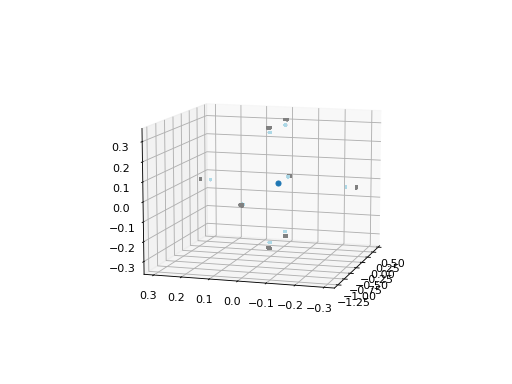

In [119]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scene.plot(ax)

In [183]:
@torch.no_grad()
def make_image(scene, device='cpu', nb_rays=int(1e9), batch_size=int(50e6), quantum_efficiency=True, max_iterations=2,
               add_poisson_noise=True, lookup_table=None, show_progress=True, destructive_readout=True):
    
    progress_bar = tqdm if show_progress else lambda x: x
    nb_rays_left_to_sample = nb_rays
    for _ in progress_bar(range(int(np.ceil(nb_rays / batch_size)))):
        rays = scene.light_source.sample_rays(min(batch_size, nb_rays_left_to_sample), device=device)
        
        optics.forward_ray_tracing(rays, scene, max_iterations=max_iterations)#, quantum_efficiency=quantum_efficiency)
        nb_rays_left_to_sample -= batch_size

        del rays
        torch.cuda.empty_cache()
        
        
    readouts = []    
    for i, obj in enumerate(scene.objects):
        print(i)
        if type(obj) == optics.Sensor:
            readouts.append(obj.readout(add_poisson_noise=add_poisson_noise, 
                                        destructive_readout=destructive_readout))

    return readouts

In [177]:
outgoing_rays = optics.Rays(torch.tensor([[0., 0., 0.]]), torch.tensor([[1., 0., 0.]]))

In [178]:
ray_out_o = [outgoing_rays.origins.clone()]
for i in range(1):
    outgoing_rays, t, mask = optics.ray_tracing.ray_tracing.trace_rays(outgoing_rays, scene)
    ray_out_o.append(outgoing_rays.origins.clone())


In [195]:
from gradoptics.integrator import HierarchicalSamplingIntegrator
integrator = HierarchicalSamplingIntegrator(64, 64)

In [197]:
scene.objects

In [260]:
scene.light_source.bounding_shape = optics.BoundingSphere(radii=0.03, 
                                                         xc=0, yc=0, zc=0)

In [261]:
idxs = torch.cartesian_prod(torch.arange(scene.objects[1].resolution[0]//2, -scene.objects[1].resolution[0]//2, -1), 
                            torch.arange(scene.objects[1].resolution[1]//2, -scene.objects[1].resolution[1]//2, -1))

pix_x, pix_y = idxs.T

In [262]:
batch_size=100
batch_pix_x = pix_x.split(batch_size)
batch_pix_y = pix_y.split(batch_size)

In [263]:
intensities_all = []
for i in tqdm(range((len(batch_pix_x)))):
    intensities_all.append(optics.ray_tracing.ray_tracing.render_pixels(scene.objects[1], 
                                                           scene.objects[0], 
                                                           scene, scene.light_source, 1, 5, 
                                                           batch_pix_x[i], batch_pix_y[i],
                                                           integrator, device='cpu',max_iterations=2))

KeyboardInterrupt: 

In [265]:
device='cpu'
px_i = batch_pix_x[100]
px_j = batch_pix_y[100]
# Sampling on the sensor
ray_origins, p_a1 = scene.objects[1].sample_on_pixels(1, px_i, px_j, device=device)
ray_origins = ray_origins.reshape(-1, 3)
ray_origins = ray_origins.expand([5] + list(ray_origins.shape)
                                 ).transpose(0, 1).reshape(-1, 3)

# Sampling directions
p_prime, p_a2 = scene.objects[0].sample_points_on_lens(ray_origins.shape[0])
ray_directions = optics.batch_vector(p_prime[:, 0] - ray_origins[:, 0], p_prime[:, 1] - ray_origins[:, 1],
                                     p_prime[:, 2] - ray_origins[:, 2])

# @Todo, generalization needed
sensor_normal = torch.tensor([1, 0, 0], device=device)
cos_theta = optics.optics.vector.cos_theta(sensor_normal[None, ...], ray_directions)

rays = optics.Rays(ray_origins.type(torch.float).to(device), ray_directions.type(torch.float).to(device),
                   meta={'cos_theta': cos_theta}, device=device)

In [281]:
intensities = optics.backward_ray_tracing(rays, scene, light_source, integrator, max_iterations=1)

In [285]:
intensities = torch.zeros(rays.get_size(), dtype=torch.double)

# Labelling the rays
rays.meta['track_idx'] = torch.linspace(0, rays.get_size() - 1, rays.get_size(),
                                                 dtype=torch.long)

In [287]:
outgoing_rays, t, mask = optics.ray_tracing.ray_tracing.trace_rays(rays, scene)

In [293]:
outgoing_rays2, t, mask = optics.ray_tracing.ray_tracing.trace_rays(outgoing_rays, scene)

In [298]:
scene.objects[1].position

tensor([0.3146, 0.0000, 0.3146], dtype=torch.float64)

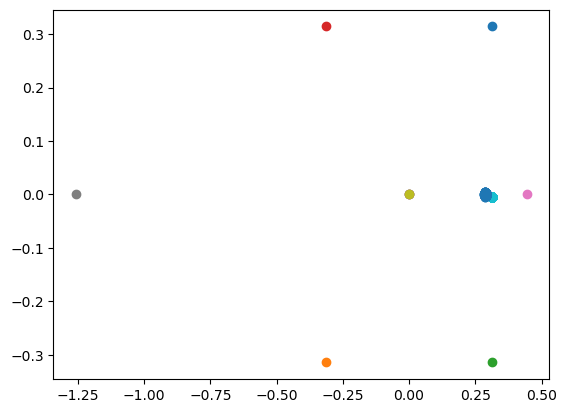

In [299]:
for i in range(len(scene.objects)):
    if type(scene.objects[i]) == optics.Sensor:
        plt.scatter(scene.objects[i].position[0], scene.objects[i].position[2])
plt.scatter(0, 0)

plt.scatter(rays.origins[:, 0], rays.origins[:, 1])
plt.scatter(outgoing_rays.origins[:, 0], outgoing_rays.origins[:, 1])
plt.scatter(outgoing_rays2.origins[mask][:, 0], outgoing_rays2.origins[mask][:, 1])


In [303]:
scene.objects[0].transform.transform

tensor([[-0.7071,  0.0000,  0.7071,  0.2874],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [-0.7071,  0.0000, -0.7071,  0.2874],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [282]:


for i in range(max_iterations):
    outgoing_rays, t, mask = trace_rays(incident_rays, scene)

    # Potential intersection with the light source
    t_min, t_max = light_source.bounding_shape.get_ray_intersection_(incident_rays)

    # Mask for the rays that hit the light source rather than the object found in trace_rays
    new_mask = (t_min < t) & (t_min < t_max)

    # Computing the intensities for the rays that have hit the light source
    if new_mask.sum() > 0:
        intensities[incident_rays.meta['track_idx'][new_mask]] = integrator.compute_integral(
            incident_rays[new_mask], light_source.pdf, t_min[new_mask], t_max[new_mask]
        ) * incident_rays[new_mask].luminosities

    # Rays that are still in the scene, and have not hit the light source
    incident_rays = outgoing_rays[mask & (~new_mask)]

return intensities

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

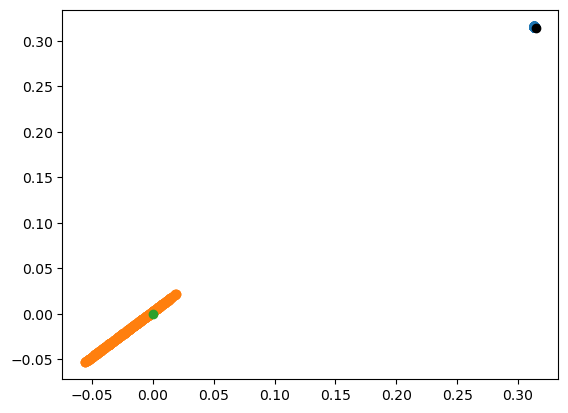

In [266]:
plt.scatter(rays.origins[:, 0], rays.origins[:, 2])

plt.scatter(rays.origins[:, 0]+0.5*rays.directions[:, 0], rays.origins[:, 2]+0.5*rays.directions[:, 0])
for i in range(2):#len(scene.objects)):
    if type(scene.objects[i]) == optics.Sensor:
        plt.scatter(scene.objects[i].position[0], scene.objects[i].position[2], c='k')

plt.scatter(0, 0)

In [223]:
(torch.tensor(camera_params[0]['position']).norm()*-0.0942)/(-0.0942-1)

tensor(0.0350, dtype=torch.float64)

In [226]:
-0.1*(torch.tensor(camera_params[0]['position']).norm())/(-0.1-1)

tensor(0.0369, dtype=torch.float64)

In [220]:
camera_params[0]['f']/(camera_params[0]['f']-torch.tensor(camera_params[0]['position']).norm())

tensor(-0.0942, dtype=torch.float64)

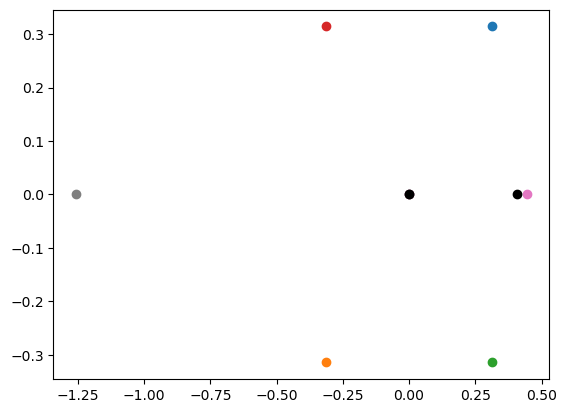

In [180]:
%matplotlib inline
for i in range(len(scene.objects)):
    if type(scene.objects[i]) == optics.Sensor:
        plt.scatter(scene.objects[i].position[0], scene.objects[i].position[2])

for i in range(len(ray_out_o)):
    plt.scatter(ray_out_o[i][:, 0], ray_out_o[i][:, 2], c='k')

In [191]:
test = make_image(scene, nb_rays=int(1000), batch_size=int(100), add_poisson_noise=False)

100%|██████████| 10/10 [01:05<00:00,  6.55s/it]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [194]:
torch.where(torch.stack(test) > 0)

(tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64))

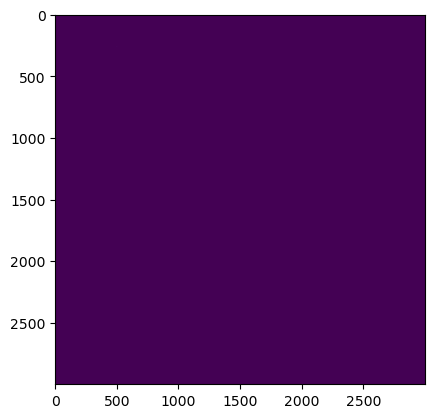

In [190]:
plt.imshow(test[5].cpu())
plt.show()

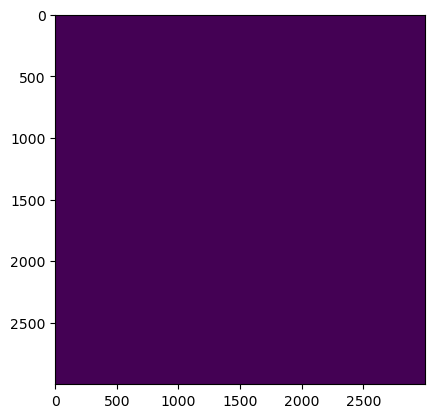

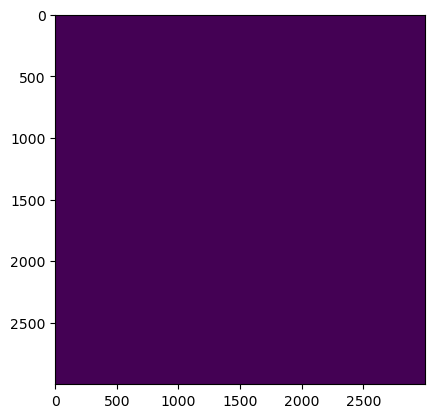

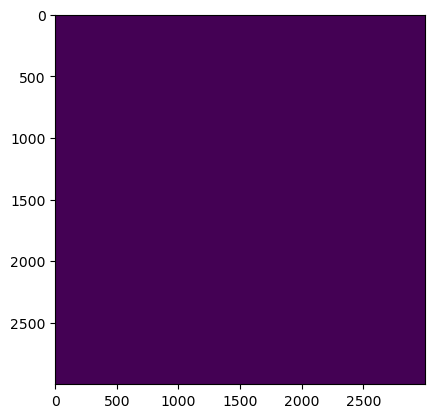

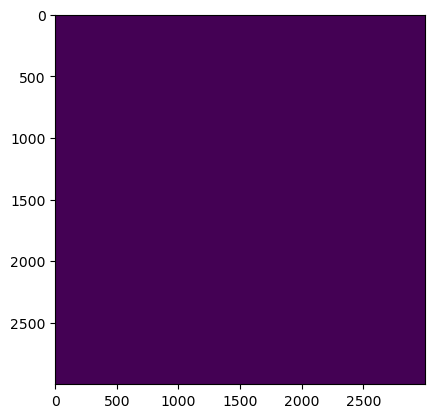

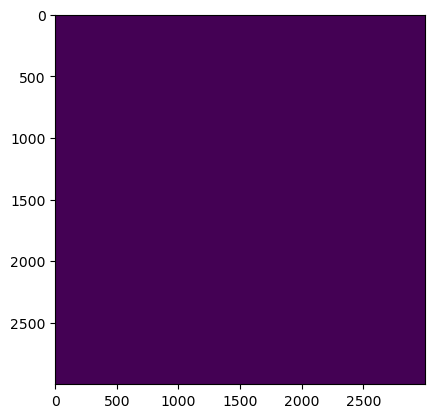

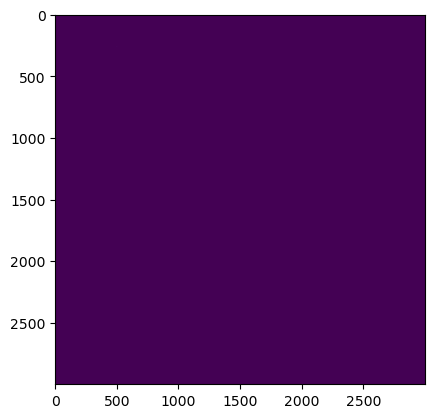

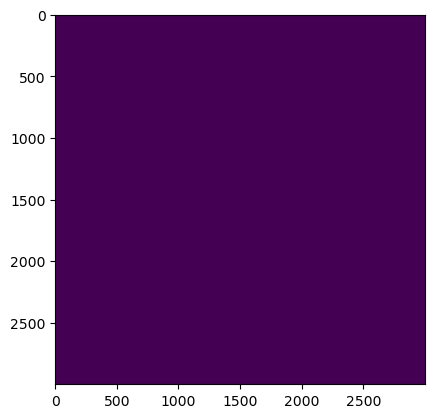

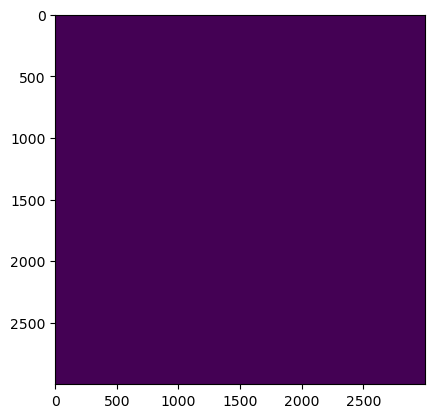

In [185]:
%matplotlib inline
for i in range(len(test)):
    plt.imshow(test[i].cpu())
    plt.show()